In [16]:
# fit dirichlet multinomial scale factor across replicate
import tensorflow_probability as tfp

In [8]:
fl='/home/hsher/scratch/ABC_2rep/counts/genome/megatables/K562_rep4.tsv.gz'
fl2='/home/hsher/scratch/ABC_2rep/counts/genome/megatables/K562_rep6.tsv.gz'

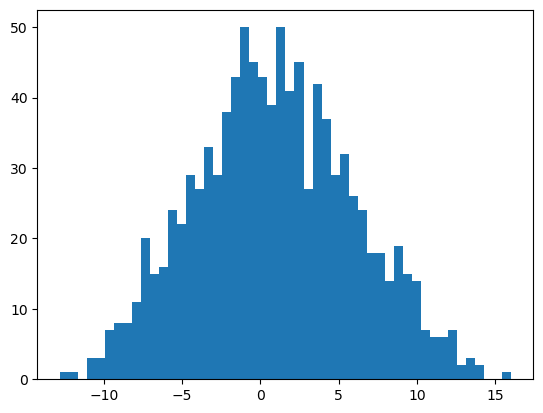

In [18]:
import numpy as np
import matplotlib.pyplot as plt
x_train = np.random.normal(loc=1, scale=5, size=1000).astype('float32')[:, np.newaxis]

plt.hist(x_train, bins=50);

In [19]:
import tensorflow as tf

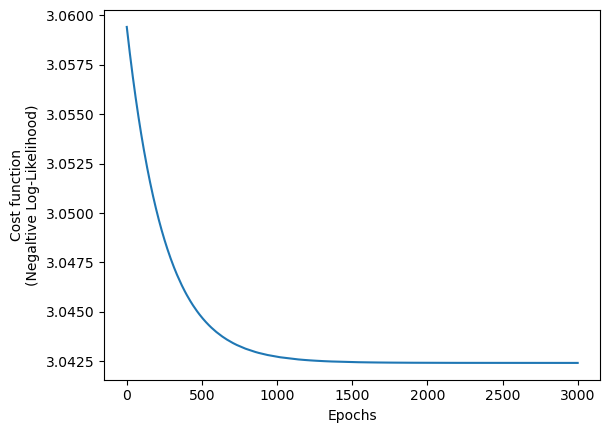

In [38]:
normal = tfp.distributions.Normal(loc=tf.Variable(0., name='loc'), scale=5)
normal.trainable_variables
def nll(dist, x_train):
    """Calculates the negative log-likelihood for a given distribution
    and a data set."""
    return -tf.reduce_mean(dist.log_prob(x_train))

@tf.function
def get_loss_and_grads(dist, x_train):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        loss = nll(dist, x_train)
        grads = tape.gradient(loss, dist.trainable_variables)
    return loss, grads

# Instantiate a stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)


# Custom training loop
epochs = 3000
nll_loss = []
for _ in range(epochs):
    loss, grads = get_loss_and_grads(normal, x_train)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
    nll_loss.append(loss)
 
plt.plot(nll_loss)
plt.xlabel('Epochs')
plt.ylabel('Cost function\n(Negaltive Log-Likelihood)');

In [39]:
print(f'True Value: {x_train.mean()}')
print(f'Estimated Value: {normal.trainable_variables[0].numpy()}')

True Value: 0.9221978187561035
Estimated Value: 0.9199257493019104


In [50]:
# tutorial
import tensorflow_probability as tfp
import tensorflow as tf
import time as tm

tfd = tfp.distributions

N = 1_000_000
P = 250


def loss(par, x, y):
    alpha = par[0]
    beta = tf.expand_dims(par[1:], 1)
    dist = tfd.Bernoulli(alpha + x @ beta)
    return -tf.reduce_sum(dist.log_prob(y))


@tf.function
def loss_and_gradient(par, x, y):
    return tfp.math.value_and_gradient(lambda par: loss(par, x, y), par)


def fit(x, y):
    init = tf.zeros(tf.shape(x)[1] + 1)
    opt = tfp.optimizer.lbfgs_minimize(
        lambda par: loss_and_gradient(par, x, y), init, max_iterations=1000
    )
    return opt


tf.random.set_seed(123)

alpha_true = tfd.Normal(0.666, 1.0).sample()
beta_true = tfd.Normal(0.0, 3.14).sample([P, 1])

x = tfd.Normal(0.0, 1.0).sample([N, P])
y = tfd.Bernoulli(alpha_true + x @ beta_true).sample()

start = tm.time()
mle = fit(x, y)
end = tm.time()

In [57]:
x.shape, y.shape

(TensorShape([1000000, 250]), TensorShape([1000000, 1]))

In [60]:
mle.position.shape

TensorShape([251])

In [47]:
def dm_loss(scale, fraction, count):
    concentration = scale*fraction
    
    dist = tfd.DirichletMultinomial(tf.math.reduce_sum(count, axis = 1), concentration)
    return -tf.reduce_sum(dist.log_prob(count))

@tf.function
def loss_and_gradient_dm(scale, fraction, count):
    return tfp.math.value_and_gradient(lambda scale: dm_loss(scale, fraction, count), scale)


def fit_dm(count, fraction):
    init = tf.ones(1)
    opt = tfp.optimizer.lbfgs_minimize(
        lambda scale: loss_and_gradient_dm(scale, fraction, count), init, max_iterations=1000
    )
    return opt

In [41]:
import pandas as pd
data1 = pd.read_csv(fl, sep = '\t')
data2 = pd.read_csv(fl2, sep = '\t')


In [106]:
data1 = data1.loc[(~data1.sum(axis = 1).eq(0))&(~data2.sum(axis = 1).eq(0))]
data2 = data2.loc[(~data1.sum(axis = 1).eq(0))&(~data2.sum(axis = 1).eq(0))]

In [108]:
data1.shape, data2.shape

((962657, 10), (962657, 10))

In [109]:
fraction2 = data2.div(data2.sum(axis = 1), axis = 0)

In [149]:
psuedocounted_count

,K562_rep6.IGF2BP2,K562_rep6.RBFOX2,K562_rep6.PUM2,K562_rep6.FAM120A,K562_rep6.DDX3,K562_rep6.ZC3H11A,K562_rep6.EIF3G,K562_rep6.PRPF8,K562_rep6.LIN28B,K562_rep6.SF3B4
0,32.916073,44.585963,7.108556,59.326253,25.493181,41.453224,10.199044,33.350273,20.600977,32.966456
1,43.916073,54.585963,8.108556,64.326253,28.493181,37.453224,9.199044,41.350273,18.600977,42.966456
2,27.916073,37.585963,8.108556,38.326253,18.493181,25.453224,8.199044,31.350273,10.600977,28.966456
3,29.916073,32.585963,5.108556,46.326253,22.493181,18.453224,7.199044,23.350273,13.600977,19.966456
4,5.916073,12.585963,2.108556,12.326253,7.493181,6.453224,2.199044,9.350273,6.600977,8.966456
...,...,...,...,...,...,...,...,...,...,...
5926992,19.916073,33.585963,2.108556,39.326253,16.493181,22.453224,5.199044,17.350273,7.600977,15.966456
5926993,13.916073,33.585963,4.108556,50.326253,12.493181,20.453224,3.199044,13.350273,13.600977,25.966456
5926994,12.916073,29.585963,0.108556,34.326253,20.493181,14.453224,4.199044,14.350273,10.600977,19.966456
5926995,8.916073,8.585963,1.108556,18.326253,11.493181,3.453224,5.199044,8.350273,7.600977,4.966456


In [140]:
gross = data2.sum(axis = 0)
gross_mean = gross/gross.sum()
pseudocount=10

psuedocounted_count = data2+gross_mean*pseudocount
fraction2 = psuedocounted_count.div(psuedocounted_count.sum(axis = 1), axis = 0)
fraction = tf.convert_to_tensor(psuedocounted_fraction, dtype=dtype)

count = tf.convert_to_tensor(data1, dtype=dtype)


In [141]:
dtype = tf.float32
start = tm.time()
mle = fit_dm(count, fraction)
end = tm.time()

In [150]:
mle.position

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1498080.2], dtype=float32)>

In [151]:
mle

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=True>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=False>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=3>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=34>, position=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1498080.2], dtype=float32)>, objective_value=<tf.Tensor: shape=(), dtype=float32, numpy=2560157.5>, objective_gradient=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.01008093], dtype=float32)>, position_deltas=<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 1.4980794e+06],
       [-1.2500000e-01]], dtype=float32)>, gradient_deltas=<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00]

In [157]:
data1

,K562_rep4.IGF2BP2,K562_rep4.RBFOX2,K562_rep4.PUM2,K562_rep4.FAM120A,K562_rep4.DDX3,K562_rep4.ZC3H11A,K562_rep4.EIF3G,K562_rep4.PRPF8,K562_rep4.LIN28B,K562_rep4.SF3B4
0,26,39,8,43,25,36,7,26,21,19
1,37,48,5,57,20,33,8,41,25,34
2,36,37,6,42,20,20,4,31,10,23
3,22,31,2,35,12,28,3,18,11,14
4,7,5,2,9,3,6,3,6,2,2
...,...,...,...,...,...,...,...,...,...,...
5926992,6,15,3,40,9,19,3,13,16,19
5926993,13,17,2,33,8,17,0,6,7,11
5926994,9,10,1,21,6,7,1,4,4,6
5926995,5,2,0,10,2,3,1,3,3,1


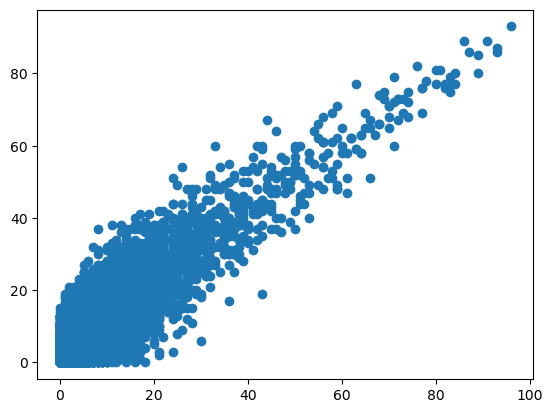

In [159]:
import matplotlib.pyplot as plt
plt.scatter(data1['K562_rep4.IGF2BP2'], data2['K562_rep6.IGF2BP2'])

In [146]:
import numpy as np
fitdata = []

for scale in np.linspace(0.5,10,6):
    dist = tfp.distributions.DirichletMultinomial(tf.math.reduce_sum(count, axis = 1), 
                                                  (psuedocounted_fraction)*scale)
    loglik=tf.math.reduce_sum(dist.log_prob(count))
    fitdata.append((scale, loglik.numpy()))

In [147]:
fitdata

[(0.5, -4469788.0),
 (2.4, -3542219.0),
 (4.3, -3341671.0),
 (6.199999999999999, -3249357.5),
 (8.1, -3195461.0),
 (10.0, -3159843.0)]

<Axes: xlabel='0'>

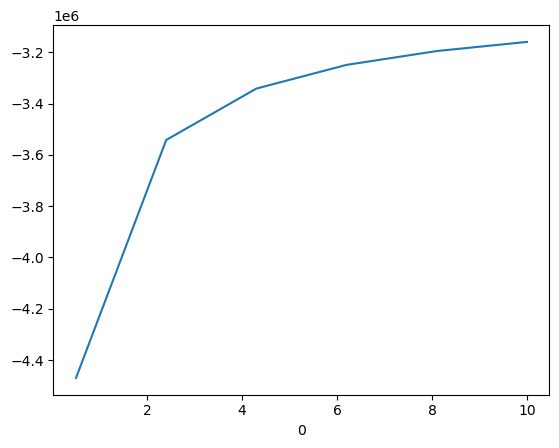

In [148]:
pd.DataFrame(fitdata).set_index(0)[1].plot()

In [ ]:
normal = tfp.distributions.Normal(loc=tf.Variable(0., name='loc'), scale=5)
normal.trainable_variables
def nll(dist, x_train):
    """Calculates the negative log-likelihood for a given distribution
    and a data set."""
    return -tf.reduce_mean(dist.log_prob(x_train))

@tf.function
def get_loss_and_grads(dist, x_train):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        loss = nll(dist, x_train)
        grads = tape.gradient(loss, dist.trainable_variables)
    return loss, grads

# Instantiate a stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)


# Custom training loop
epochs = 3000
nll_loss = []
for _ in range(epochs):
    loss, grads = get_loss_and_grads(normal, x_train)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
    nll_loss.append(loss)
 
plt.plot(nll_loss)
plt.xlabel('Epochs')
plt.ylabel('Cost function\n(Negaltive Log-Likelihood)');